# Notebook #5: Predicciones

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Librería para el acceso a variables y funciones
# -----------------------------------------------------------------------
import sys
sys.path.append("../../")
from src import soporte_predicciones as sp

In [3]:
df = pd.read_csv("../../datos/modelo1/csv_estandarizado.csv", index_col=0)

In [4]:
df.head()

,price,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,rooms_0,rooms_1,rooms_2,...,bathrooms_1,bathrooms_2,bathrooms_3,exterior_False,exterior_True,size_standard,distance_standard,municipality_standard,floor_standard,hasLift_standard
0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.178670,-0.672168,0.325518,0.068339,0.604026
1,750.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.744316,0.063729,1.620745,-1.266396,-0.256239
2,590.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,-0.047589,-0.293150,-2.521675,-1.251244,-0.256239
3,684.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,-0.669800,-0.379764,0.325518,-1.251244,-4.185620
4,600.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.914010,1.753756,-2.296178,0.068339,-0.256239


In [5]:
X = df.drop("price", axis = 1)
y = df[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

- Para nuestros modelos, utilizaremos modelos de ensamble, específicamente el Random Forest y el Gradient Boost, que se usan en modelos de clasificación y de regresión.

- El Random Forest puede funcionar mejor cuando tenemos conjuntos de datos grandes o mucho ruido en nuestros datos, pero puede ser menos efectivo para captar variaciones más pequeñas. Es más sencillo configurar los hiperparámetros. Es un modelo de Bagging, donde creamos un bosque (paralelo), no nos quedamos con un sólo árbol, y el resultado es la media de sus medias.

- Con Gradient Boosting, las predicciones suelen ser más acertadas, dado que la secuencia árboles tiende a reducir los errores. Normalmente tarda más para converger. Es más probable tener overfitting. En los modelos de Boosting, se aprende de los datos en la primera iteración (se predice la variable respuesta) pero en las posteriores, aprende de los errores cometidos, que son los que entran en el siguiente árbol, siendo el resultado final el del último árbol.

## Random Forest

In [26]:
params_rf = {
    'n_estimators': [40, 50, 60], # de árboles que queremos en nuestro bosque
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15, 20], # mínimo de datos que debe tener la madre
    'min_samples_leaf': [10, 15, 20], # mínimo de datos que debe tener el hijo
    'max_leaf_nodes': [30, 50, 90] # de nodos finales
}

In [27]:
modelo_final_rf, df_metricas_rf = sp.probar_modelo(X_train, y_train["price"].values, X_test, y_test, params_rf, RandomForestRegressor())

Los mejores parámetros para el modelo con RandomForestRegressor() son:
    {'max_depth': 5, 'max_leaf_nodes': 90, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 40}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.459526,29.718185,1481.400536,38.488966
test,0.387595,32.975278,1950.328607,44.162525


- La métrica del 22 nos indica cuán de bien explican nuestras variables predictoras a la variable respuesta. Idealmente está lo más cercano a 1 posible, siendo el train y el test también lo más similares.

- En este caso, vemos que los r2 no se alejan demasiado, pero son bajas, así que, antes de intentar mejorar este modelo, pasaremos a una segunda iteración, donde cambiaremos el tratamiento de los nulos (eliminaremos en lugar de sustituir por las medianas) y el encoding.

In [8]:
df_importancia_rf = pd.DataFrame(modelo_final_rf.feature_importances_, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)
df_importancia_rf

,Importancia
municipality_standard,0.635939
size_standard,0.187289
floor_standard,0.070169
distance_standard,0.054533
rooms_1,0.020583
hasLift_standard,0.007787
exterior_True,0.007492
propertyType_studio,0.003790
rooms_2,0.003460
propertyType_flat,0.002986


<Axes: xlabel='Importancia', ylabel='None'>

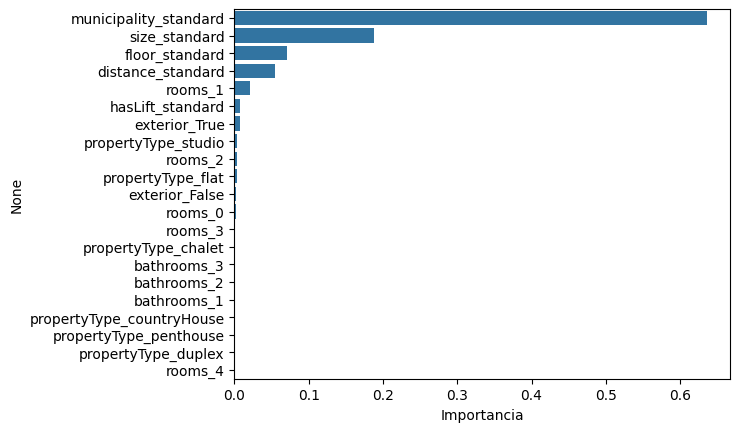

In [9]:
sns.barplot(x = "Importancia", y= df_importancia_rf.index, data = df_importancia_rf)

## Gradient Boosting

In [10]:
params_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_leaf_nodes': [40]
}

In [11]:
modelo_final_gb, df_metricas_gb = sp.probar_modelo(X_train, y_train["price"].values, X_test, y_test, params_gb, GradientBoostingRegressor())

Los mejores parámetros para el modelo con GradientBoostingRegressor() son:
    {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.705923,22.359368,806.044428,28.390922
test,0.378880,32.527328,1978.083274,44.475648


- Vemos r2 que se alejan demasiado, así que, no dedicaremos tiempo a mejorar las métricas.